# Coding Assignment 2

Team:

* Olivia Dalglish (od4)
* Arindam Saha (saha2)

Contribution:
* Olivia: Part 2
* Arindam: Part 1

In addition to the above, we discussed our approaches and checked each other's work.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

np.random.seed(1735)


## Part 1

## Part 2

In [2]:
def train_test_split(X, Y):
    """Split data into training and testing partitions"""
    n = len(Y)

    indices = np.arange(0, n)
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*n))]
    train_ind = indices[len(test_ind):]
    
    X_train = X.iloc[train_ind]
    Y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y[test_ind]

    return X_train, Y_train, X_test, Y_test

def normalize(X_train, X_test):
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [3]:
def run(X, Y, models=[], niter=50):
    results = defaultdict(list)
    for i in range(niter):
        runner = Predictor(X, Y) #initalize new predictor object - data will be resplit to train/test
        for model_type in models:
            model_run_results = runner.run_model(model_type)
            for model_name, mse in model_run_results.items():
                results[model_name].append(mse)
    return results

class Predictor:
    def __init__(self, X, Y):
        X_train, Y_train, X_test, Y_test = train_test_split(X, Y)
        X_train, X_test = normalize(X_train, X_test)
        self.X_train = X_train
        self.Y_train = Y_train.to_numpy()
        self.X_test = X_test
        self.Y_test = Y_test.to_numpy()

    def run_model(self, model_type):
        results = {}
        fit_method = getattr(self, f"fit_{model_type}")
        models = fit_method()
        for model_name, model in models.items():
            if model_name == "lasso_model_refit":
                mse = self.mse(model, self.X_train[:, self.lasso_refit_nonzero_indices], self.Y_train)
            else:
                mse = self.mse(model, self.X_test, self.Y_test)
            results[model_name] = mse
        return results
        
    def mse(self, model, X_test, Y_test):
        return mean_squared_error(Y_test, model.predict(X_test))
    
    def fit_linear(self):
        model = lm().fit(self.X_train, self.Y_train)
        return {"linear_model": model}

    def fit_ridge(self):
        ridge_alphas = np.logspace(-10, 1, 100)
        ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, 
                          scoring = 'neg_mean_squared_error')
        ridgecv.fit(self.X_train, self.Y_train)
        ridgecv.alpha_
        
        ridge_model = Ridge(alpha = ridgecv.alpha_)
        ridge_model.fit(self.X_train, self.Y_train)

        return {"ridge_model": ridge_model}

    def fit_lasso(self):
        lasso_alphas = np.logspace(-10, 1, 100)
        lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
        lassocv.fit(self.X_train, self.Y_train)
        lassocv.alpha_
        
        mean_mse = np.mean(lassocv.mse_path_, axis=1)
        std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 
        
        cv_alphas = lassocv.alphas_
        min_idx = np.argmin(mean_mse)
        
        alpha_min = cv_alphas[min_idx]
        
        threshold = mean_mse[min_idx] + std_mse[min_idx]
        alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])
        
        alpha_min, alpha_1se  #alpha_min = lassocv.alpha_

        # lasso model with min alpha
        lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
        lasso_model_min.fit(self.X_train, self.Y_train)

        # lasso model with 1se alpha
        lasso_model_1se = Lasso(alpha = alpha_1se, max_iter=10000)
        lasso_model_1se.fit(self.X_train, self.Y_train)

        # lasso model refit with 1se
        self.lasso_refit_nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
        lm_refit = lm()
        lm_refit.fit(self.X_train[:, self.lasso_refit_nonzero_indices], self.Y_train)
        print(f"Number of 0-coef features: {len(np.where(lasso_model_1se.coef_ == 0)[0])}")

        return {"lasso_model_1se": lasso_model_1se, "lasso_model_min": lasso_model_min, "lasso_model_refit": lm_refit}

    def fit_pcr(self):
        pcr = PCR()
        pcr.fit(self.X_train, self.Y_train)
        return {"pcr": pcr}

class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] +=  np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)


## Simulation Study Case 1

In [4]:
url = "Coding2_Data1.csv"
myData = pd.read_csv(url)
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

results = run(X, Y, models = ["linear", "ridge", "lasso", "pcr"], niter=50)

Number of 0-coef features: 41
Number of 0-coef features: 60
Number of 0-coef features: 58
Number of 0-coef features: 47
Number of 0-coef features: 51
Number of 0-coef features: 53
Number of 0-coef features: 52
Number of 0-coef features: 55
Number of 0-coef features: 50
Number of 0-coef features: 57
Number of 0-coef features: 60
Number of 0-coef features: 63
Number of 0-coef features: 42
Number of 0-coef features: 67
Number of 0-coef features: 58
Number of 0-coef features: 60
Number of 0-coef features: 59
Number of 0-coef features: 61
Number of 0-coef features: 46
Number of 0-coef features: 23
Number of 0-coef features: 60
Number of 0-coef features: 55
Number of 0-coef features: 63
Number of 0-coef features: 51
Number of 0-coef features: 56
Number of 0-coef features: 59
Number of 0-coef features: 59
Number of 0-coef features: 70
Number of 0-coef features: 72
Number of 0-coef features: 64
Number of 0-coef features: 64
Number of 0-coef features: 34
Number of 0-coef features: 55
Number of 

In [5]:
print(pd.DataFrame(results).describe())


       linear_model  ridge_model  lasso_model_1se  lasso_model_min  \
count     50.000000    50.000000        50.000000        50.000000   
mean       0.031976     0.027803         0.030440         0.028620   
std        0.008711     0.004991         0.005260         0.005547   
min        0.018276     0.017282         0.018231         0.016565   
25%        0.026322     0.024816         0.026858         0.024955   
50%        0.030159     0.027259         0.031358         0.029043   
75%        0.035008     0.031459         0.034586         0.032518   
max        0.066685     0.040647         0.039866         0.044575   

       lasso_model_refit        pcr  
count          50.000000  50.000000  
mean            0.019782   0.030180  
std             0.002834   0.006062  
min             0.013356   0.017584  
25%             0.017843   0.026903  
50%             0.019663   0.029852  
75%             0.021106   0.033014  
max             0.026605   0.048273  


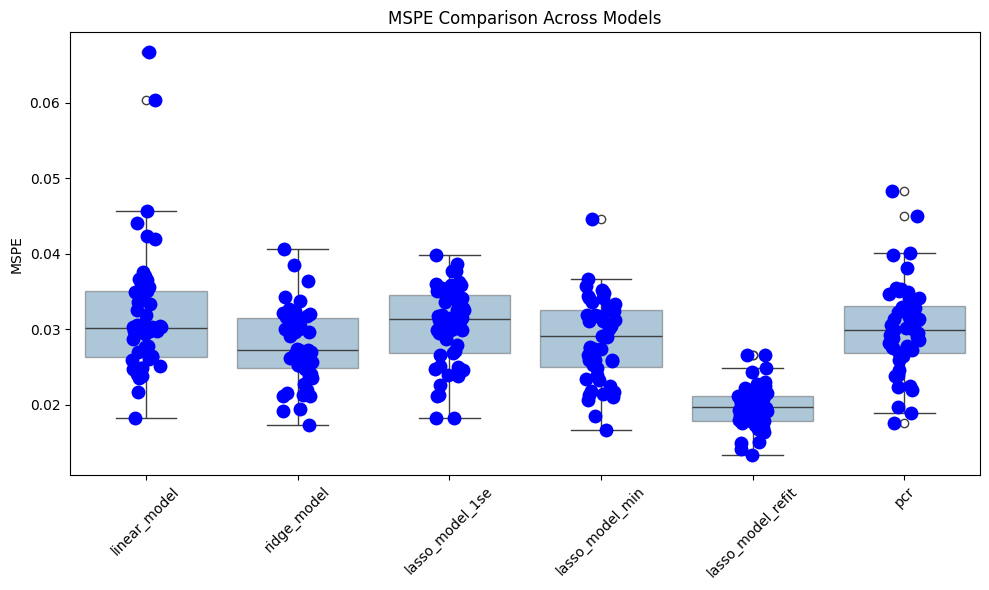

In [7]:
data_list = [(model, mspe) for model, mspe_values in results.items() for mspe in mspe_values]
models, mspe_values = zip(*data_list)

plt.figure(figsize=(10, 6))

sns.stripplot(x=models, y=mspe_values, jitter=True, color="blue", size=10)

sns.boxplot(x=models, y=mspe_values, boxprops={'alpha': 0.4})
plt.title('MSPE Comparison Across Models')
plt.ylabel('MSPE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Discussion

* Which procedure or procedures yield the best performance in terms of MSPE?
  - Lasso Model Refit yields the best performance in terms of MSPE
* Conversely, which procedure or procedures show the poorest performance?
  - Linear Model yields the poorest performance in terms of MSPE as well as a high relative standard deviation
* In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?
  - Both procedures have similar means, but Lasso Model Min has a slightly lower MSPE. Lasso Model 1se has slightly less variability (lower std), however, which means the results are more likely to vary with the addition of training data.
* Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?
  - Refitting is advantageous as doing so gives us the best performance out of all the methods, including the lasso 1se/lasso min models
* Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?
  - Yes, it is warranted because it helps simplify the model, and the performance is better in terms of MSPE. With fewer features, the model is more explainable with fewer features, so we can take advantage of the better performance and simpler model with the refitted lasso.

## Simulation Study Case 2

In [8]:
url = "Coding2_Data2.csv"
myData = pd.read_csv(url)
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

In [9]:
X.shape, Y.shape

((506, 591), (506,))

In [10]:
results = run(X, Y, models = ["ridge", "lasso", "pcr"], niter=50)

Number of 0-coef features: 582
Number of 0-coef features: 584
Number of 0-coef features: 585
Number of 0-coef features: 584
Number of 0-coef features: 580
Number of 0-coef features: 584
Number of 0-coef features: 585
Number of 0-coef features: 586
Number of 0-coef features: 581
Number of 0-coef features: 587
Number of 0-coef features: 584
Number of 0-coef features: 587
Number of 0-coef features: 585
Number of 0-coef features: 585
Number of 0-coef features: 586
Number of 0-coef features: 579
Number of 0-coef features: 563
Number of 0-coef features: 584
Number of 0-coef features: 585
Number of 0-coef features: 577
Number of 0-coef features: 578
Number of 0-coef features: 578
Number of 0-coef features: 585
Number of 0-coef features: 581
Number of 0-coef features: 562
Number of 0-coef features: 587
Number of 0-coef features: 579
Number of 0-coef features: 584
Number of 0-coef features: 586
Number of 0-coef features: 579
Number of 0-coef features: 583
Number of 0-coef features: 587
Number o

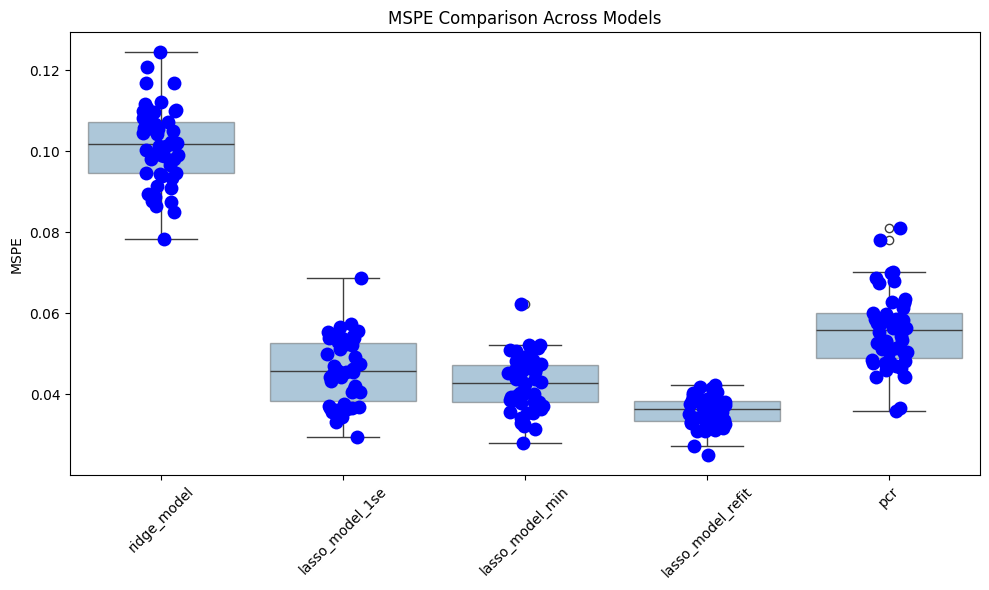

In [11]:
data_list = [(model, mspe) for model, mspe_values in results.items() for mspe in mspe_values]
models, mspe_values = zip(*data_list)

plt.figure(figsize=(10, 6))

sns.stripplot(x=models, y=mspe_values, jitter=True, color="blue", size=10)

sns.boxplot(x=models, y=mspe_values, boxprops={'alpha': 0.4})
plt.title('MSPE Comparison Across Models')
plt.ylabel('MSPE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Discussion

* Which procedure or procedures yield the best performance in terms of MSPE?
  - The Lasso model refitted had the lowest average MPSE
* Conversely, which procedure or procedures show the poorest performance?
  - The ridge model had the highest average MPSE
* Have you observed any procedure or procedures that performed well in Case I but exhibited poorer performance in Case II, or vice versa? If so, please offer an explanation.
* Given that Coding2_Data2.csv includes all features found in Coding2_Data1.csv, one might anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case
  - Ridge regression performed on par with Lasso in the first case study simulation, and decreased in performance in the second case study. This is likely from noise in the additional features in the second case study. Ridge does not actually shrink variables to 0, so added features will result in additional noise in the model if there is no true relationship between some of the added features and the target variable. 
I. Do your simulation results corroborate this expectation? If not, please offer an explanation.
* The simulation does not corroborate this expectation. The refitted lasso model performs the best in both case studies, but it is lower (\~0.01) in Case study 1 and higher (\~0.03) in Case study 2. This could be due to different splits of training/test between the two simulations (overfitting issue), or from multicollinearity, where there are relationships between variables making it harder to deduce the true relationships between the features and the targets during training. 

In [13]:
print(pd.DataFrame(results).describe())

       ridge_model  lasso_model_1se  lasso_model_min  lasso_model_refit  \
count    50.000000        50.000000        50.000000          50.000000   
mean      0.101590         0.045849         0.042629           0.035752   
std       0.009573         0.008127         0.006844           0.003642   
min       0.078240         0.029280         0.027899           0.025015   
25%       0.094660         0.038187         0.037967           0.033351   
50%       0.101919         0.045648         0.042845           0.036332   
75%       0.107202         0.052628         0.047277           0.038382   
max       0.124428         0.068605         0.062166           0.042268   

             pcr  
count  50.000000  
mean    0.055634  
std     0.009264  
min     0.035721  
25%     0.048825  
50%     0.055816  
75%     0.060056  
max     0.081115  
